# ARIMA Model

### What is an ARIMA model?

**AR:** Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

**I:** Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

**MA:** Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


##### The parameters of the ARIMA model are defined as follows:

**p:** The number of lag observations included in the model, also called the lag order.

**d:** The number of times that the raw observations are differenced, also called the degree of differencing.

**q:** The size of the moving average window, also called the order of moving average.

### Import Packages

In [1]:
import os
import pandas as pd
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
#from statsmodels.graphics.tsaplots import plot_predict
import matplotlib.pyplot as plt
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
#from pmdarima import auto_arima

#from pmdarima.arima import auto_arima
import time

### Get Data

In [2]:
data_dir = "/gpfs/gpfs0/project/SDS/instructional/ds5110_sp23_finalproject/"

In [64]:
agg_data_monthly = pd.read_csv(data_dir + "aggregate_data_daily.csv", parse_dates=True)

agg_data_monthly['date'] = pd.to_datetime(agg_data_monthly.date).dt.strftime("%Y-%m")
agg_data_monthly.sort_values(by='date',ascending=False)
agg_data_monthly = agg_data_monthly.groupby(["date"]).mean()
agg_data_monthly.index = pd.DatetimeIndex(agg_data_monthly.index)

In [4]:
agg_data_monthly

,close,high,low,open,volume,sma5,sma10,sma15,sma20,ema5,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
date,,,,,,,,,,,,,,,,,,,,,
2015-02-01,131662.912162,131731.962139,131594.593652,131663.189685,8.503200e+05,131662.011608,131660.819711,131659.676136,131658.562157,131662.006043,...,4357.561959,4369.613899,4370.019643,4369.802102,-4385.739670,144.314157,144.348478,131663.155985,1840.013415,31.804441
2015-03-01,134029.758441,134082.054823,133978.258255,134030.547220,8.040483e+05,134030.564807,134031.773348,134032.948755,134034.115853,134030.595511,...,4301.527729,4363.302999,4362.909433,4348.010373,-4452.793975,121.596730,121.375631,134030.023840,1847.401287,37.171440
2015-04-01,130201.195084,130266.651300,130138.918525,130203.040503,8.539350e+05,130203.097652,130205.376031,130207.693171,130210.041150,130203.075672,...,4287.893228,4368.236247,4368.190636,4304.143851,-4455.096967,134.322677,134.278603,130202.254970,1851.892854,31.992780
2015-05-01,128641.653752,128704.332831,128579.880830,128641.012747,8.135002e+05,128640.610455,128639.269904,128637.826158,128636.305322,128640.595981,...,4388.580276,4389.315057,4389.297944,4405.436932,-4329.397532,138.806640,138.903845,128641.955804,1825.777097,30.229657
2015-06-01,124706.381832,124767.464227,124646.785098,124706.886219,7.266782e+05,124706.322466,124706.883907,124707.614293,124708.402519,124706.475508,...,4339.317817,4373.236584,4372.739802,4348.760656,-4395.193296,159.197854,158.025514,124706.877053,1817.625579,29.932399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,230863.450167,230978.767774,230745.520532,230866.058386,1.448845e+06,230868.711402,230874.964632,230881.148452,230887.442827,230868.632032,...,4379.717965,4357.944556,4356.245928,4505.697509,-4471.704659,237.883652,238.359557,230862.579491,1870.091575,35.176274
2022-07-01,241987.177965,242087.336783,241879.517528,241985.589576,1.580275e+06,241980.687769,241972.727131,241964.676067,241956.691392,241980.696624,...,4507.674906,4387.999140,4385.595891,4554.002588,-4268.994815,211.634003,211.829925,241984.677426,1879.349286,33.146919
2022-08-01,259750.665171,259861.312188,259632.224208,259752.128813,1.964583e+06,259748.066631,259745.184835,259742.403811,259739.655517,259748.125308,...,4520.383278,4395.555166,4395.089151,4549.961870,-4280.710826,233.364440,233.733630,259748.067189,1864.359398,34.524005


In [5]:
len(agg_data_monthly)

93

In [60]:
# Normalize
# agg_data_monthly.close = agg_data_monthly.close / agg_data_monthly.close.abs().max()

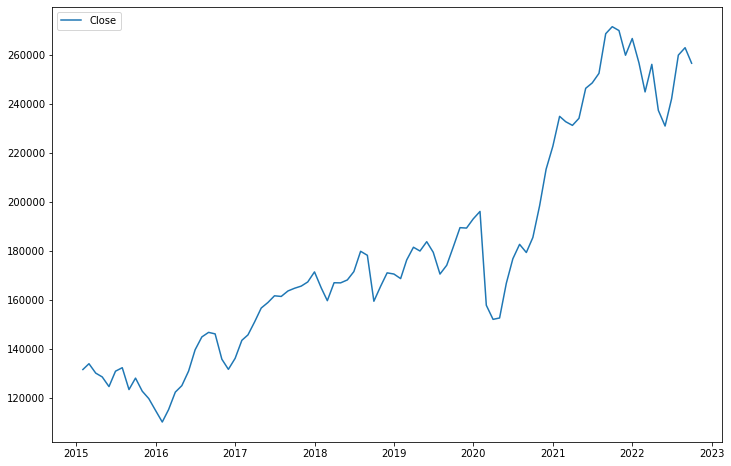

In [65]:
plt.figure(figsize=(12,8))
plt.plot(agg_data_monthly.index, agg_data_monthly.close, label="Close")
plt.legend(loc="upper left")
plt.show()

In [67]:
train_monthly = agg_data_monthly[:75]
test_monthly = agg_data_monthly[75:]
train_monthly.index = pd.DatetimeIndex(train_monthly.index).to_period('M')
test_monthly.index = pd.DatetimeIndex(test_monthly.index).to_period('M')

## ARIMA

In [8]:
# modelauto = auto_arima(train.close, trace=True, suppress_warnings=True)
# print(modelauto.summary())

/home/ak7ra/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ak7ra/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


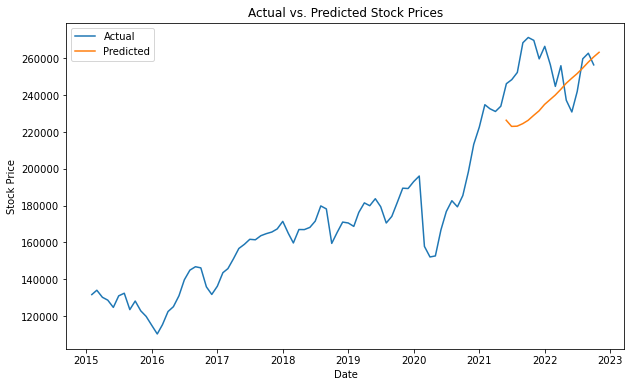

In [68]:
model = ARIMA(train_monthly.close, order=(3,2,12)) #order=(3,2,12)
model = model.fit()

pred = model.predict(start=75, end = 92, typ='levels')

#pred

# Visualize predictions and actual stock prices
plt.figure(figsize=(10,6))
plt.plot(agg_data_monthly.close, label='Actual')
plt.plot(test_monthly.index, pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

In [17]:
history = train_monthly.close[75:]
predictions = list()

# walk-forward validation
for t in range(len(test_monthly)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = train.close[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
mse = mean_squared_error(test.close, predictions)
print('Test MSE: %.3f' % mse)

/home/ak7ra/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/ak7ra/.local/lib/python3.8/site-packages/statsmodels/base/model.py:531: RuntimeWarning: invalid value encountered in scalar divide
  return -self.loglike(params, *args) / nobs
/home/ak7ra/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


IndexError: index 0 is out of bounds for axis 0 with size 0